In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
sns.set_style('whitegrid')

In [3]:
import category_encoders as ce

In [4]:
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth

In [5]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [6]:
import tensorflow as tf

In [7]:
import keras
from keras.models import Model
import kerastuner

In [8]:
from keras.layers import Dense, Input, Dropout

In [49]:
def fast_loss(arr_true,arr_pred):
    assert arr_true.shape == arr_pred.shape
    epsilon = 1e-20
    y = arr_true
    y_c = 1-arr_true
    y_hat = np.log(np.abs(arr_pred)+epsilon)
    y_hat_c = np.log(np.abs(1-arr_pred)+epsilon)
    runner = np.sum(y * y_hat + y_c * y_hat_c)
    return -1 / (arr_true.shape[0]*arr_true.shape[1]) * runner

## Keras notebook with clustering added, raw inputs to NN
In this notebook, do PCA on `g-` and `c-` features separately to cluster, then pass raw inputs plus clusters to NN.
1. Plot PCA explained variance.
1. Visualize 2D PCA of this dataset.
1. Select an optimal Mean Shift bandwidth and number of PCA dimensions to cluster on, then cluster.
1. Make cluster id a categorical feature, hot encode it.
1. Pass features and cluster id to three layer NN.
1. Tune the network & train up the best candidate.

### This version
Hack out the clustering exploration and hardcode the bw30, 2D bandwidth.
Hack out the tuner and go with the hardcoded model from the previous raw-inputs notebook.
Calculate the log loss here so as not to take up scoring chances on Kaggle.

In [10]:
tf_df = pd.read_csv('../train_features.csv',index_col='sig_id')
tts_df = pd.read_csv('../train_targets_scored.csv',index_col='sig_id')
tf_df['cp_type']=tf_df['cp_type'].astype('category')
scaler = MinMaxScaler(feature_range=(-0.5,0.5))
tf_df['cp_time']=scaler.fit_transform((np.array(tf_df['cp_time'])).reshape(-1,1))
tf_df['cp_dose']=tf_df['cp_dose'].astype('category')

In [11]:
oenc = ce.ordinal.OrdinalEncoder()
tf_df = oenc.fit_transform(tf_df)
tf_df.sample(5)

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
sig_id,,,,,,,,,,,,,,,,,,,,,
id_f60fe0087,1,0.0,1,-0.5219,0.1022,-0.1297,0.5591,-1.1960,-1.6930,-0.6188,...,-0.6261,-2.1440,-0.3391,-3.0990,-0.5826,0.5375,0.5113,0.2707,-1.0200,-0.2763
id_801bb18e1,1,0.0,1,1.9630,-2.1280,0.0017,0.5831,2.5180,0.7979,1.3740,...,-0.3203,-0.1104,-0.4862,-0.7279,0.4452,-1.0190,-0.4927,-1.6730,-2.1210,0.3475
id_3c87e6253,1,-0.5,1,0.2192,0.4785,2.0330,-0.0534,-0.4128,-0.3449,-0.0512,...,-0.2353,-0.5609,0.8464,-0.6068,0.5180,-0.4832,0.1162,0.3042,0.3074,0.4916
id_a0764cc51,1,-0.5,1,5.1830,0.7361,2.1850,2.0050,1.1870,-1.9570,-1.3220,...,-7.3180,-6.6420,-6.3470,-8.4400,-6.5260,-1.9180,-6.3230,-4.0370,-4.3000,-2.4400
id_cbb3e6f5c,1,0.0,2,-0.3684,0.1838,-0.6387,-0.3298,-0.0493,0.0668,-0.2451,...,-0.0345,-0.5872,-0.0103,-0.5175,0.1426,0.1095,-0.1131,-0.0934,0.5375,-0.4306


In [12]:
tf_df['cp_type']=tf_df['cp_type']-1
tf_df['cp_dose']=tf_df['cp_dose']-1
tf_df.head()

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,0,-0.5,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
id_000779bfc,0,0.5,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
id_000a6266a,0,0.0,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
id_0015fd391,0,0.0,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
id_001626bd3,0,0.5,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


1. Plot PCA explained variance for `g-` and `c-` features.

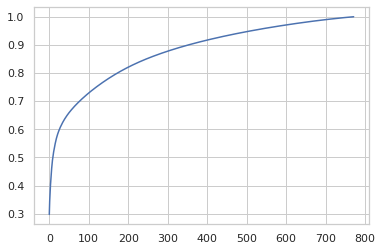

In [13]:
pca_g = PCA()
g_pca_df = pd.DataFrame(pca_g.fit_transform(tf_df.loc[:,'g-0':'g-771']),index=tf_df.index)
g_var_explain = np.cumsum(pca_g.explained_variance_ratio_)
plt.plot(g_var_explain)
plt.show()

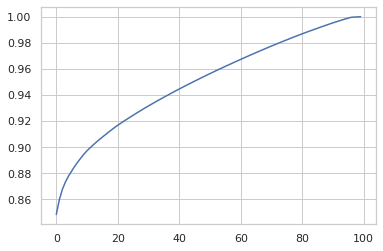

In [14]:
pca_c = PCA()
c_pca_df = pd.DataFrame(pca_c.fit_transform(tf_df.loc[:,'c-0':'c-99']),index=tf_df.index)
c_var_explain = np.cumsum(pca_c.explained_variance_ratio_)
plt.plot(c_var_explain)
plt.show()

1. Pick a number of PCA dimension to pass as NN inputs:

In [15]:
g_var_explain[g_var_explain<0.6]

array([0.29734508, 0.34410798, 0.3745819 , 0.40162744, 0.42326748,
       0.44320877, 0.46072195, 0.47737419, 0.48957602, 0.50039008,
       0.51033589, 0.51953365, 0.52730413, 0.53490378, 0.54224014,
       0.54930426, 0.5556887 , 0.56180496, 0.56751932, 0.57271804,
       0.57760574, 0.58201959, 0.58627179, 0.59023977, 0.59400926,
       0.59756794])

In [16]:
c_var_explain[c_var_explain<0.86]

array([0.84853809, 0.85991709])

Ok, THAT'S interesting. Straight-no-chaser, as-provided `c-` variation is concentrated in that first PCA dimension, which I'm strongly suspecting is basically "SCREECH KILL KILL" (or if I'm being less cryptic, the primary effect of drugs on the cell viability, if there is any, is broad spectrum toxicity). Let's check the components; I did that once...

In [17]:
pca_c.components_[0,:]

array([-0.08971376, -0.10644446, -0.11072059, -0.07823494, -0.11310322,
       -0.10078192, -0.11997049, -0.0726784 , -0.10468699, -0.08259113,
       -0.11140378, -0.11101845, -0.11329532, -0.1179659 , -0.08060507,
       -0.1056513 , -0.07695712, -0.11049436, -0.12126021, -0.08234373,
       -0.1041336 , -0.10733322, -0.0788044 , -0.07823044, -0.10512867,
       -0.09914511, -0.12150564, -0.10145941, -0.09999348, -0.07524781,
       -0.08984445, -0.10738283, -0.09064616, -0.11790382, -0.10448263,
       -0.09047495, -0.1037094 , -0.06094476, -0.12372822, -0.09656622,
       -0.10769672, -0.10616105, -0.11130871, -0.10373436, -0.10298574,
       -0.11192068, -0.09156892, -0.09876522, -0.10558409, -0.08858353,
       -0.09176933, -0.10584508, -0.10875898, -0.09057859, -0.09879073,
       -0.11409073, -0.07302758, -0.1012047 , -0.05850324, -0.11428751,
       -0.11385208, -0.08748818, -0.10217313, -0.1230526 , -0.09170258,
       -0.11661172, -0.10732093, -0.10915382, -0.09788615, -0.07

SCREECH KILL KILL (I believe that was Shining Force I, by the way)

In [18]:
pca_c.components_[1,:]

array([ 0.1101463 , -0.06771955, -0.03404396, -0.00180231, -0.07534766,
       -0.06441954, -0.07374153,  0.11120286, -0.01567694, -0.07525599,
        0.01619381, -0.05184685,  0.02176484, -0.02443001,  0.10515687,
        0.03016075,  0.21255264,  0.12691543, -0.2747343 ,  0.06549926,
        0.16814088, -0.048238  , -0.24909016,  0.02744452, -0.03689499,
       -0.04011473, -0.15472372,  0.13227548, -0.06714169,  0.13011023,
        0.08051755,  0.06047939,  0.17896899,  0.02799002, -0.01910719,
        0.13953236, -0.11916257,  0.06113058, -0.13932054,  0.10348494,
       -0.06301378, -0.03557659, -0.02379655, -0.05974368,  0.13835461,
        0.06887495, -0.02225931, -0.03415981, -0.23159697, -0.12171719,
       -0.14988872,  0.01280294, -0.04208199,  0.17699338, -0.00565648,
       -0.07420319,  0.08754961, -0.1032785 ,  0.0428991 ,  0.04517922,
        0.03143235,  0.16497721, -0.01536609, -0.15141172, -0.05098021,
       -0.04689361, -0.0317495 , -0.10117603,  0.13451299,  0.06

Note that the coefficients are now not all negative; this component picks winner cell types and loser cell types.

2. Visualize 2D PCA of this dataset.

<AxesSubplot:xlabel='0', ylabel='0'>

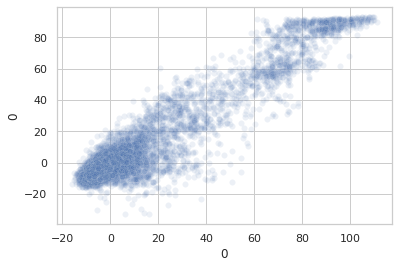

In [19]:
sns.scatterplot(x=g_pca_df[0],y=c_pca_df[0],alpha=0.1)

This breakdown doesn't look as friendly for clustering until I turn alpha down. Meanwhile, why do the first genetic activation component and the SCREECH KILL KILL component covary so strongly?

In [20]:
pca_g.components_[0,:]

array([ 5.53246127e-02, -1.58525631e-04,  1.05175076e-02,  7.15220862e-03,
        2.30255984e-02, -1.17511714e-02,  6.25641099e-03, -3.92960995e-02,
       -6.41859684e-02, -3.08449114e-02, -5.04009907e-02,  2.12190636e-02,
       -2.31165221e-02,  4.18796917e-02, -3.29443674e-02, -3.36047759e-03,
       -4.73824237e-02, -3.58621456e-02,  4.38583492e-03, -1.60226674e-03,
       -3.29427921e-02, -6.46195994e-03,  1.72477018e-04, -8.75743732e-03,
       -3.38128983e-02, -1.40356687e-02, -3.54874353e-02,  8.37797509e-03,
       -3.42583031e-02, -2.78724799e-02, -5.39863771e-02,  6.37238017e-02,
       -1.85259882e-02,  9.61765028e-04, -9.34873276e-03,  1.79990478e-02,
       -2.81570516e-02, -1.02034313e-01,  9.32322594e-02,  3.45450114e-02,
       -4.03076474e-02, -4.12312078e-02, -1.39338630e-02, -4.17086512e-03,
       -2.81784660e-04, -1.37378255e-02,  4.12157765e-02,  2.81731328e-03,
        2.50406539e-02,  2.26993564e-02, -1.03553851e-01,  2.43090148e-02,
       -2.23072603e-02,  

Nothing obvious. I wondered if it was a global TURN DEM GENES OFF signal, but no, certainly not.

<AxesSubplot:xlabel='0', ylabel='1'>

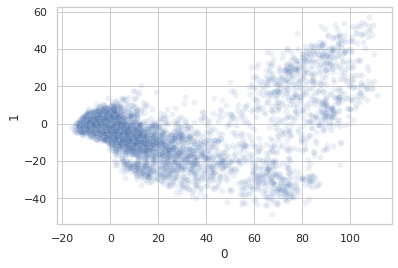

In [21]:
sns.scatterplot(x=g_pca_df[0],y=g_pca_df[1],alpha=0.1)

<AxesSubplot:xlabel='0', ylabel='1'>

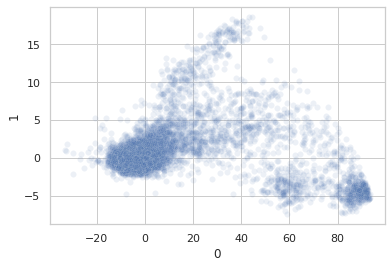

In [22]:
sns.scatterplot(x=c_pca_df[0],y=c_pca_df[1],alpha=0.1)

<AxesSubplot:xlabel='0', ylabel='2'>

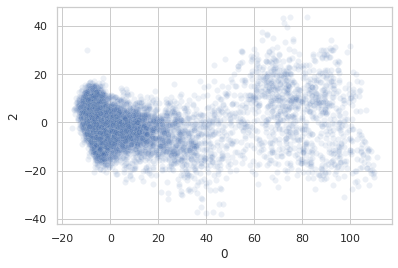

In [23]:
sns.scatterplot(x=g_pca_df[0],y=g_pca_df[2],alpha=0.1)

<AxesSubplot:xlabel='0', ylabel='2'>

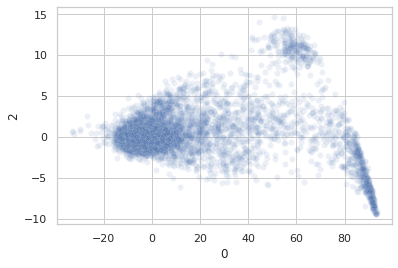

In [24]:
sns.scatterplot(x=c_pca_df[0],y=c_pca_df[2],alpha=0.1)

In the original clustering notebook I checked the total range of the first several PCA columns and then shrank them to be proportional to the amount of variation those dimensions explained. I didn't have any theoretical justification for this; it just sounded reasonable.

Here I will at least look at the six dimensions I have chosen and what their ranges are. I may simply go ahead and cluster after stretching them to have consistent ranges, or I may squint at the pairplot and decide which ones to stretch relative to others.

I'm going to put the `c` dimensions in front because I suspect they will cluster better.

In [25]:
top_six_df = pd.concat([c_pca_df.loc[:,0:2],g_pca_df.loc[:,0:2]],axis=1)
top_six_df.columns = ['c0','c1','c2','g0','g1','g2']
ranges = top_six_df.max()-top_six_df.min()
ranges

c0    126.274358
c1     26.116123
c2     24.195421
g0    126.771720
g1    105.892402
g2     82.084268
dtype: float64

In [26]:
t6scaler = MinMaxScaler()
cluster_df = pd.DataFrame(t6scaler.fit_transform(top_six_df),
                          index=top_six_df.index,
                          columns=top_six_df.columns)
cluster_df.head()

,c0,c1,c2,g0,g1,g2
sig_id,,,,,,
id_000644bb2,0.203641,0.308912,0.392035,0.060027,0.454355,0.416942
id_000779bfc,0.202553,0.257087,0.396663,0.073002,0.490896,0.578668
id_000a6266a,0.243526,0.294398,0.396881,0.111641,0.480585,0.458304
id_0015fd391,0.371792,0.566739,0.400866,0.198017,0.413769,0.450402
id_001626bd3,0.211369,0.295778,0.403855,0.067992,0.461327,0.568124


3. Conduct silhouette tests of the data reduced to various PCA dimensions, up to 6.

Previously I found MeanShift seemed far and away better than KMeans or DBSCAN.

I also found that the silhouette scores did in fact go down if I fed the algorithms the raw PCA output rather than my questionably rescaled values, so questionably rescaled values it is.

I can take some steps to speed up MeanShift by
1. calculating `estimate_bandwidth` ahead of time in an optimized fashion, using less than all the points
1. using bin seeding with a cutoff number of points for bins
1. setting n_jobs=2

Let me deliberately plan out how I will gridsearch, save models, and plot the metrics for each hyperparameter choice in [ #dims, bandwidth ]. I recalculate the bandwidth at different quantiles.

In [27]:
bw30 = []
for dim in range(6):
    # quantile = 0.3 is the default
    bw30.append(estimate_bandwidth(cluster_df.iloc[:,0:dim+1],quantile=0.3,n_samples=1000,n_jobs=2))
    print(f'Bandwidth for {dim+1} dimensions is {bw30[dim]}\n')

Bandwidth for 1 dimensions is 0.051835677942629194

Bandwidth for 2 dimensions is 0.07420975650688903

Bandwidth for 3 dimensions is 0.09101919502095929

Bandwidth for 4 dimensions is 0.11452954572576132

Bandwidth for 5 dimensions is 0.12398050757559648

Bandwidth for 6 dimensions is 0.14571247336408055



I want
* a plot of silhouette scores per number of PCA dimensions clustered
* a different color and legend entry for each bandwidth quantile
* I will need to fit a MeanShift model at each of these combinations
    * save the model
        * perhaps in a two-layer dictionary with bw -> #dims
    * save the silhouette score
        * preferably in a dataframe with column labels `bw30, bw50, bw80`

In [28]:
data = cluster_df.iloc[:,0:2]
ms_model = MeanShift(bandwidth=0.0742,
                                    bin_seeding=True,
                                    min_bin_freq=10,
                                    n_jobs=2).fit(data)
labels = pd.Series(ms_model.labels_,index=tf_df.index)

In [29]:
labels.value_counts()

0     21739
1       473
3       362
5       350
2       237
4       137
7       126
6       119
9       112
8        82
10       77
dtype: int64

4. Hot encode the cluster labels. Definitely want to drop a feature so that these columns are not mutually collinear, and it seems reasonable to drop cluster 0 and regard the small clusters as 'flavor' (or is that 'flava').

In [30]:
ohenc = OneHotEncoder(drop='first',sparse=False,dtype=np.int)
cats = ohenc.fit_transform(np.array(labels).reshape(-1,1))
cats[:5,:]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

5. Pass original features and cluster id to three layer NN.
6. Tune the network & train up the best candidate.

I might want to increase the number of layers, but let's not get too far ahead of myself.
* I had the model where I was feeding PCA `g` and `c` components to the model, and at most 512 neurons per layer, peg at 512 per layer.
* I'm running a second model where the options are now 512, 1024, 2048 per layer on Kaggle now.
* Now I'm going to throw the scaled original features in along with the clusters and the large layer sizes.

Speaking of another notebook, at some point I should implement the "if it's a control experiment, predict 0" circuit breaker. That may or may not be contrary to the spirit of the thing in terms of creating a tool for actual use, but it would be instructive.

In [31]:
transformer = StandardScaler()
tf_df.loc[:,'g-0':'c-99']=transformer.fit_transform(tf_df.loc[:,'g-0':'c-99'])
print(cats.shape,tf_df.shape)

(23814, 10) (23814, 875)


In [32]:
tf_arr = np.concatenate((cats,np.array(tf_df)),axis=1)
tf_arr.shape

(23814, 885)

In [33]:
tts_arr = np.array(tts_df)
tts_arr.shape

(23814, 206)

Get crackalackin'.

In [34]:
strategy = tf.distribute.get_strategy()
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  1


In [35]:
with strategy.scope():
    inputs = Input(shape=(885,))
    x = Dense(1024,activation='relu')(inputs)
    x = Dropout(0.35,input_shape=(1024,))(x)
    x = Dense(1024,activation='elu')(x)
    x = Dropout(0.35,input_shape=(256,))(x)
    x = Dense(1024,activation='elu')(x)
    x = Dropout(0.2,input_shape=(64,))(x)
    outputs = Dense(206,activation='sigmoid')(x)
    model = Model(inputs,outputs)
    model.compile("adam", 'binary_crossentropy', metrics=["binary_crossentropy","accuracy"])

In [36]:
history = model.fit(tf_arr, tts_arr, validation_split=0.2, epochs=50)

Epoch 1/50
596/596 [==============================] - 42s 71ms/step - loss: 0.0238 - binary_crossentropy: 0.0238 - accuracy: 0.0805 - val_loss: 0.0182 - val_binary_crossentropy: 0.0182 - val_accuracy: 0.1199
Epoch 2/50
596/596 [==============================] - 57s 96ms/step - loss: 0.0177 - binary_crossentropy: 0.0177 - accuracy: 0.1063 - val_loss: 0.0177 - val_binary_crossentropy: 0.0177 - val_accuracy: 0.1056
Epoch 3/50
596/596 [==============================] - 69s 115ms/step - loss: 0.0168 - binary_crossentropy: 0.0168 - accuracy: 0.1255 - val_loss: 0.0181 - val_binary_crossentropy: 0.0181 - val_accuracy: 0.1121
Epoch 4/50
596/596 [==============================] - 80s 134ms/step - loss: 0.0163 - binary_crossentropy: 0.0163 - accuracy: 0.1371 - val_loss: 0.0177 - val_binary_crossentropy: 0.0177 - val_accuracy: 0.1048
Epoch 5/50
596/596 [==============================] - 78s 131ms/step - loss: 0.0155 - binary_crossentropy: 0.0155 - accuracy: 0.1514 - val_loss: 0.0193 - val_binary_c

596/596 [==============================] - 56s 93ms/step - loss: 0.0099 - binary_crossentropy: 0.0099 - accuracy: 0.3575 - val_loss: 0.0224 - val_binary_crossentropy: 0.0224 - val_accuracy: 0.0997
Epoch 41/50
596/596 [==============================] - 56s 94ms/step - loss: 0.0097 - binary_crossentropy: 0.0097 - accuracy: 0.3688 - val_loss: 0.0233 - val_binary_crossentropy: 0.0233 - val_accuracy: 0.1008
Epoch 42/50
596/596 [==============================] - 56s 95ms/step - loss: 0.0191 - binary_crossentropy: 0.0191 - accuracy: 0.3584 - val_loss: 0.0219 - val_binary_crossentropy: 0.0219 - val_accuracy: 0.1014
Epoch 43/50
596/596 [==============================] - 63s 105ms/step - loss: 0.0096 - binary_crossentropy: 0.0096 - accuracy: 0.3674 - val_loss: 0.0235 - val_binary_crossentropy: 0.0235 - val_accuracy: 0.0976
Epoch 44/50
596/596 [==============================] - 56s 94ms/step - loss: 0.0090 - binary_crossentropy: 0.0090 - accuracy: 0.3747 - val_loss: 0.0233 - val_binary_crossentro

In [37]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 885)]             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              907264    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)             

In [38]:
model.evaluate(tf_arr,tts_arr)

745/745 [==============================] - 22s 30ms/step - loss: 0.0089 - binary_crossentropy: 0.0089 - accuracy: 0.3646


[0.008852388709783554, 0.008852388709783554, 0.36457544565200806]

In [50]:
tts_pred = model.predict(tf_arr)
fast_loss(tts_arr,tts_pred)

0.008868063512722938

Here I need to implement the same preprocessing steps to recreate the input data characteristics... in particular, mapping the test data points to the correct clusters.

In [40]:
testf_df = pd.read_csv('../test_features.csv',index_col='sig_id')

In [41]:
testf_df['cp_type']=testf_df['cp_type'].astype('category')
testf_df['cp_time']=scaler.transform((np.array(testf_df['cp_time'])).reshape(-1,1))
testf_df['cp_dose']=testf_df['cp_dose'].astype('category')
testf_df = oenc.transform(testf_df)
testf_df['cp_type']=testf_df['cp_type']-1
testf_df['cp_dose']=testf_df['cp_dose']-1

Got to get the new cluster ids, encode them, then reassemble the input matrix.

In [42]:
g_test_df = pd.DataFrame(pca_g.transform(testf_df.loc[:,'g-0':'g-771']),index=testf_df.index)
c_test_df = pd.DataFrame(pca_c.transform(testf_df.loc[:,'c-0':'c-99']),index=testf_df.index)
# remember that the clustering was done on just the first two c dimensions
# however, the scaler took in 6 dimensions
# I suppose it won't matter what I feed to the garbage dimensions of the scaler
# but I'll do it the same way for consistency: 3 c, 3 g
test_six_df = pd.concat([c_test_df.loc[:,0:2],g_test_df.loc[:,0:2]],axis=1)
test_six_df.columns=top_six_df.columns
tcluster_df = pd.DataFrame(t6scaler.transform(test_six_df),
                          index=test_six_df.index,
                          columns=test_six_df.columns)
tcluster_df.head()

,c0,c1,c2,g0,g1,g2
sig_id,,,,,,
id_0004d9e33,0.235691,0.243136,0.347117,0.085562,0.480570,0.480080
id_001897cda,0.272467,0.287161,0.436074,0.094228,0.430544,0.434638
id_002429b5b,0.213936,0.308580,0.356619,0.053329,0.472502,0.438228
id_00276f245,0.241837,0.276511,0.339692,0.094207,0.461743,0.392647
id_0027f1083,0.186619,0.331795,0.375232,0.054899,0.476455,0.513740


In [43]:
test_labels = pd.Series(ms_model.predict(tcluster_df.loc[:,'c0':'c1']))
test_labels.value_counts()

0     3675
1       89
5       47
2       47
3       41
4       19
6       16
7       15
10      14
9       10
8        9
dtype: int64

In [44]:
test_cats = ohenc.transform(np.array(test_labels).reshape(-1,1))
test_cats[:10,:]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [45]:
testf_df.loc[:,'g-0':'c-99']=transformer.transform(testf_df.loc[:,'g-0':'c-99'])
print(test_cats.shape,testf_df.shape)

(3982, 10) (3982, 875)


In [46]:
testf_arr = np.concatenate((test_cats,np.array(testf_df)),axis=1)
testf_arr.shape

(3982, 885)

In [47]:
test_pred = model.predict(testf_arr)
sub_df = pd.DataFrame(test_pred,index=testf_df.index,columns=tts_df.columns)
sub_df.head()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,
id_0004d9e33,5.231931e-13,2.390809e-11,3.370071e-07,2.719125e-05,3.444254e-04,2.482687e-06,1.553499e-08,5.688706e-05,3.892361e-12,6.075497e-06,...,3.201144e-10,1.298821e-09,1.324945e-06,3.300588e-07,3.318848e-07,6.328445e-15,1.035329e-08,1.495120e-05,2.200958e-11,7.250403e-06
id_001897cda,1.877348e-07,1.750219e-06,3.843663e-06,6.503698e-05,4.091859e-04,3.077778e-05,1.661181e-04,4.617191e-05,1.197664e-06,9.768009e-04,...,7.739816e-06,1.034715e-05,4.141927e-04,2.908409e-04,1.198831e-04,1.613334e-09,3.237128e-04,1.280508e-05,7.793782e-10,1.389411e-05
id_002429b5b,0.000000e+00,0.000000e+00,3.583333e-25,3.660532e-13,2.039982e-13,4.667564e-24,5.110648e-27,3.081071e-25,0.000000e+00,1.940608e-16,...,2.856156e-30,9.873570e-34,2.458991e-27,1.130799e-16,1.055544e-26,0.000000e+00,8.369651e-35,1.043326e-26,0.000000e+00,4.647666e-38
id_00276f245,6.157087e-08,6.266569e-09,2.410942e-07,2.634525e-04,8.087754e-04,2.655089e-04,6.475854e-05,3.201577e-06,7.382774e-11,6.845355e-03,...,4.195060e-09,8.964406e-08,5.405961e-05,2.523065e-04,2.860129e-04,1.112101e-11,2.441858e-06,1.482152e-07,8.483828e-13,2.767462e-08
id_0027f1083,2.551132e-07,5.454120e-07,1.952169e-06,4.018843e-04,7.192194e-04,2.605071e-05,2.181117e-05,2.191663e-04,1.085201e-09,6.979108e-04,...,1.551701e-06,1.937409e-07,8.871137e-06,5.124855e-05,5.049524e-06,1.436501e-09,6.794893e-07,1.398921e-04,2.099035e-08,1.684185e-07


In [48]:
sub_df.to_csv('submission.csv')